# Проект: Продвинутые техники подготовки данных

***Примечание к проекту:***

*Данный проект — это логическое продолжение предыдущего `before_california_housing_spark`, направленное на отработку продвинутых методов предобработки и подготовки данных (после размышлений о корректности выполненной работы ранее), а именно — ***заполнение пропусков методом*** `MICE`, ***снижение размерности, применение статистических тестов, применение компрессии данных***. Данный проект будет уже выполняться без использования `Spark`, так как цели отрабатывать методы работы с этой средой в рамках этого проекта нет. Также мы возьмем датасет изначальный, без преобразованных, как было в предыдущем проекте. Задача стоит та же, что и ранее, предсказать медианную стоимость жилья для жилищного массива с помощью линейной регрессии.*

---

**Описание проекта:** Предсказание медианной стоимости жилья в Калифорнии с использованием линейной регрессии.

**Цель проекта:** Разработать и обучить модели машинного обучения для предсказания медианной стоимости дома в жилых массивах Калифорнии на основе различных комбинаций признаков, используя линейную регрессию, и сравнить разные подходы к предобработке и подготовке данных и как они влияют на предсказательную способность базовой модели.

**Описание данных:**

`california_housing_prices` — данные о жилье в Калифорнии 1990 года.

[🔗Ссылка на датасет](https://www.kaggle.com/datasets/camnugent/california-housing-prices)

**Описание признаков:**

- `longitude` — широта;
- `latitude` — долгота;
- `housing_median_age` — медианный возраст дома в пределах квартала *(меньшее число - это более новое здание)*;
- `total_rooms` — общее количество комнат в домах жилого массива;
- `total_bedrooms` — общее количество спален в домах жилого массива;
- `population` — количество человек, которые проживают в жилом массиве;
- `households` — количество домовладений в жилом массиве;
- `median_income` — медианный доход жителей жилого массива *(единица измерения 10.000 US Dollars)*;
- `median_house_value` — медианная стоимость дома в жилом массиве *(**Целевой признак** / единица измерения US Dollars)*;
- `ocean_proximity` — близость к океану.

**Ход исследования:**

- ***Подготовка данных***: загрузка и изучение общей информации из представленного датасета.
- ***Предобработка данных***: обработка пропущенных значений, корректировка типов данных и дубликатов.
- ***Исследовательский анализ данных***: изучение признаков имеющихся в датасетах, их распределение, поиск выбросов/аномалий в данных.
- ***Корреляционный анализ***:
- ***Подготовка данных:***
- ***Обучение моделей***:
- ***Анализ результатов***:

***Общий вывод***:

## Подготовка рабочей среды:

### Импорт библиотек:

In [1]:
import numpy as np
import math
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import phik
import shap
import miceforest as mf

### Базовые настройки блокнота:

In [2]:
# Стиль графиков по умолчанию
sns.set()
sns.set_context('notebook')
# Убираем ограничения на количество колонок
pd.set_option('display.max_column', None)
# Убираем ограничение на количество символов в ячейках
pd.set_option('display.max_colwidth', None)
# Константа для random_state
RANDOM_STATE = 6011994

### Функции:

In [3]:
# Функция для получения общей информации о датафрейме
def gen_info(df):
    '''
    Данная функция выводит общую информацию 
    о датафрейме, статистическое описание признаков
    и 5 рандомных строк.
    На ввод функция принимает переменную датафрейма.
    '''
    # Статистики по количественным признакам
    desc = df.describe().T

    # Подсчет коэффициента вариативности значений
    desc['cv_coef'] = desc['std'] / desc['mean']

    # Вывод результатов
    print(df.info())
    display(desc)
    display(df.sample(5, random_state=RANDOM_STATE))

In [4]:
# Функция для поиска неявных дубликатов
def hidden_dup_search(df):
    '''
    Данная функция приводит значения категориальных 
    столбцов к единому стилю и выводит их уникальные 
    значения.
    На ввод функция принимает переменную датафрейма.
    '''
    
    # Список категориальных признаков
    df_cat_col = df.select_dtypes(exclude = 'number').columns.tolist()

    # Приводим все значения к единому стилю
    # и проверяем уникальные значения для 
    # точечной проработки при необходимости
    for feature in df_cat_col:
        df[feature] = df[feature].str.lower().str.replace(' ', '_')
        print(f'Уникальные значения признака: {str(feature)}')
        print(df[feature].unique())
        print()

In [5]:
# Функция для комплексного анализа количественного признака
def analyzis_quantity(df, x_label, y_label='Частота', target=None, 
                      hue=None, system=False, discrete=False, 
                      log_scale=False, title_hist=None, title_scatter=None):
    '''
    Данная функция выводит "коробочный" график и гистограмму 
    по указанному столбцу датафрейма и его статистические метрики.
    Аргументы функции:
    df - данные (pd.Series)
    x_label - подпись для оси Х
    y_label - подпись для оси Y (по умолчанию "Частота")
    target - целевая переменная для scatter-графика (если system=True)
    hue - переменная для цветового кодирования (если system=True)
    system - флаг для построения scatter-графика
    discrete - булевое значение, дискретные значение или нет.
    log_scale - логарифмическая шкала для гистограммы
    title_hist - заголовок для гистограммы и boxplot
    title_scatter - заголовок для scatter-графика
    '''

    # Названия для графиков по умолчанию
    if title_hist is None:
        title_hist = f"Распределение {df.name if hasattr(df, 'name') else 'входной признак'}"
    if title_scatter is None:
        target_name = target.name if hasattr(target, 'name') else 'таргета'
        feature_name = df.name if hasattr(df, 'name') else 'входной признак'
        title_scatter = f"Зависимость {target_name} от {feature_name}"
    
    # Создание составного графика: boxplot + histogram
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                          figsize=(6, 4.2), 
                                          gridspec_kw={'height_ratios': (.15, .85)})
    
    # Boxplot
    sns.boxplot(x=df, orient='h', ax=ax_box)
    ax_box.set(xlabel='')

    # Histogram
    n_bins = round(1 + math.log2(len(df))) if len(df) > 1 else 10
    sns.histplot(x=df, bins=n_bins, discrete=discrete, log_scale=log_scale, ax=ax_hist)

    # Общие настройки для основной фигуры
    ax_hist.set_xlabel(x_label, fontsize=10)
    ax_hist.set_ylabel(y_label, fontsize=10)
    ax_hist.tick_params(axis='both', which='major', labelsize=10)
    fig.suptitle(title_hist, fontsize=12, fontweight='bold', y=0.95)

    # Настройка тиков для дискретных значений
    if discrete:
        ax_hist.set_xticks(np.arange(df.min(), df.max() + 1, 1))

    # Отображение первой фигуры
    fig.tight_layout()

    # Scatter plot (если запрошено)
    if system:
        if hue is not None:
            fig_2, ax_2 = plt.subplots(figsize=(7.5, 4))
        else:
            fig_2, ax_2 = plt.subplots(figsize=(6, 4))
        sns.scatterplot(x=df, y=target, alpha=0.5, hue=hue, ax=ax_2)
        fig_2.suptitle(title_scatter, fontsize=12, fontweight='bold', y=0.95)
        ax_2.set_xlabel(x_label, fontsize=10)
        ax_2.set_ylabel(target.name if hasattr(target, 'name') else 'Целевая переменная', fontsize=10)
        ax_2.tick_params(axis='both', which='major', labelsize=10)
        if hue is not None:
            ax_2.legend(bbox_to_anchor=(1.025, 1), loc='upper left', fontsize=10)
        fig_2.tight_layout()

    # Отображение графика
    plt.show()

    # Вывод статистических метрик
    display(df.describe().to_frame().T)
        
    # Проверяем нормальность распределения
    result = anderson(df.dropna())
    
    if result.statistic < result.critical_values[2]:
        distr = 'Нормальное'
    else:
        distr = 'Не является нормальным'

    test_anderson = {'':['Статистика:', 
                         "Критические значения:", 
                         'Распределение'], 
                     'Тест на нормальность распределения (порог=0.05):': [result.statistic, 
                                                                          result.critical_values, 
                                                                          distr]
                    }
    display(pd.DataFrame(test_anderson).set_index(''))

In [6]:
# Функция для анализа категорийных значений

def analyzis_category(df, name, kind='bar'):
    '''
    Данная функция выводит столбчатый график
    по указанному столбцу датафрейма и его значения 
    в табличном виде.
    Аргументы функции:
    df - данные
    name - название графика
    kind - ориентация графика вертикальная или 
    горизонтальная, принимает значения "bar" и "barh".
    '''
    # Подсчитываем количество каждого значения
    category_count = df.value_counts(ascending=True)

    # Создание столбчатого графика
    plot_bar = category_count.plot(kind=kind, figsize=(9, 6), grid=True)

    # Настройка заголовка и подписей
    if kind == 'bar':
        plt.title(name, fontsize=14)
        plt.xlabel('')
        plt.ylabel('Частота')
        plt.xticks(rotation=0)
    
    else:
        plt.title(name, fontsize=14)
        plt.xlabel('Частота')
        plt.ylabel('')
        plt.xticks(rotation=0)

    # Отображаем график
    plt.tight_layout()
    plt.show()

    # Вывод значений в табличном виде
    print(category_count)

In [7]:
# Построение таблицы с расчитанным VIF
def vif_factor(data, columns):
    '''
    Данная функция расчитываем VIF-фактор
    для количественных признаков датафрейма.
    На ввод функция принимает:
    data - датафрейм
    columns - список количественных признаков.
    '''
    vif_data = pd.DataFrame()
    vif_data['input attribute'] = columns
    vif_data['vif'] = ([variance_inflation_factor(data[columns].values, i) 
                        for i in range(data[columns].shape[1])])
    return vif_data

In [8]:
# Функция для линейной компрессии данных
def linear_compress(df, threshold, ratio):
    '''
    Функция для линейной копрессии данных,
    пики превышающие порог сжимаются на
    коэффициент ratio.
    
    Аргументы:
    df - pd.Series (оригинальный признак для компрессии);
    threshold - порог срабатывания компрессора (передавать значение квантиля);
    ratio - коэффициент сжатия.

    Вывод: pd.Series.
    '''
    thr = df.quantile(threshold)
    def ln_compress(x):
        if x <= thr:
            return x
        else:
            return thr + (x - thr) / ratio
    return df.map(ln_compress)

In [9]:
# Функция для степенной компрессии данных
def power_compress(df, threshold, power):
    '''
    Функция для степенной копрессии данных,
    пики превышающие порог масштабируются c
    соответствнно размеру коэффициента power.
    
    Аргументы:
    df - pd.Series (оригинальный признак для компрессии);
    threshold - порог срабатывания компрессора (передавать значение квантиля);
    power - степень сжатия.

    Вывод: pd.Series.
    '''
    thr = df.quantile(threshold)
    def pw_compress(x):
        if x <= thr:
            return x
        else:
            return thr + (x - thr) ** power
    
    return df.map(pw_compress)

In [10]:
# Функция для логарифмической компрессии данных
def log_compress(df, threshold, scale):
    '''
    Функция для логарифмической копрессии данных,
    пики превышающие порог сжимаются практичиески
    до уровня порога, увеличения коэффициента
    scale может немного ослабить силу сжатия.
    
    Аргументы:
    df - pd.Series (оригинальный признак для компрессии);
    threshold - порог срабатывания компрессора (передавать значение квантиля);
    scale - коэффициент ослабления силы сжатия.

    Вывод: pd.Series.
    '''
    thr = df.quantile(threshold)
    def lg_compress(x):
        if x <= thr:
            return x
        else:
            return thr + np.log1p(x - thr) * scale
    
    return df.map(lg_compress)

## Общая информация о данных:

### Загрузка данных:

In [11]:
df = pd.read_csv('./housing.csv')

### Знакомство с данными:

In [12]:
gen_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


,count,mean,std,min,25%,50%,75%,max,cv_coef
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100,-0.016756
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500,0.059945
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000,0.439448
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000,0.827698
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000,0.783432
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000,0.794444
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000,0.765364
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001,0.490825
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000,0.557855


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
15688,-122.43,37.79,52.0,3486.0,847.0,1248.0,813.0,7.2623,500001.0,NEAR BAY
8874,-118.45,34.06,52.0,204.0,34.0,1154.0,28.0,9.3370,500001.0,<1H OCEAN
7813,-118.11,33.90,35.0,2604.0,495.0,1465.0,470.0,4.4896,184600.0,<1H OCEAN
3994,-118.57,34.17,35.0,2072.0,318.0,908.0,342.0,6.0928,327300.0,<1H OCEAN
11439,-117.98,33.61,17.0,2054.0,291.0,836.0,288.0,6.8939,383900.0,NEAR OCEAN


### Вывод:

В данном разделе мы познакомились с общей информацией о датафрейме и теперь можем приблизительно составить план для предобработки данных и дальнейшей работе:

- Строки с пропущенными значениями надо рассмотреть и понять природу их возникновения, по возможности их восстановить, но их количество не так велико *(около 1%)*, если там будет наблюдатся сложная зависимость, имеет смысл просто от них отказаться, чтобы не снижать качество данных;
- После заполнения или удаления пропусков можем часть признаков преобразовать в целочисленные типы данных;
- Изменим масштаб значений признака `median_income` в изначальный вид, для удобства восприятия *(умножим на 10000)*;
- Необходимо данные проверить на наличие явных и неявных дубликатов.

## Предобработка данных:

### Пропущенные значения:

Рассмотрим строки с пропущенными значениям и попытаемся понять природу их возникновения.

In [13]:
df_na = df.query('total_bedrooms.isna()')

In [14]:
df_na.sample(15, random_state=RANDOM_STATE)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
18346,-122.15,37.43,20.0,11709.0,NaN,7604.0,3589.0,1.9045,375000.0,NEAR BAY
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0,NEAR OCEAN
6835,-118.12,34.08,35.0,2248.0,NaN,1762.0,622.0,3.0000,253900.0,<1H OCEAN
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY
19391,-120.85,37.78,25.0,421.0,NaN,303.0,106.0,2.2679,71300.0,INLAND
16757,-122.48,37.70,33.0,4492.0,NaN,3477.0,1537.0,3.0546,297900.0,NEAR OCEAN
17198,-119.75,34.45,6.0,2864.0,NaN,1404.0,603.0,5.5073,263800.0,NEAR OCEAN
14386,-117.23,32.75,5.0,1824.0,NaN,892.0,426.0,3.4286,137500.0,NEAR OCEAN
5665,-118.29,33.73,30.0,3161.0,NaN,1865.0,771.0,2.7139,231700.0,NEAR OCEAN
3921,-118.56,34.20,35.0,2273.0,NaN,1431.0,403.0,4.0789,196700.0,<1H OCEAN


На данном этапе достаточно сложно выявить закономерность, по которой стоит расчитывать средние значения, заполняя пропуски медианой будет слишком поверхностно и грубо, таким образом мы снизим качество данных, поэтому принято следующее решение, применить метод `MICE` для заполнения пропусков, обычно такой метод дает более точные значения, тем не менее при обучении моделей мы рассмотрим варианты, когда пропуски просто удалены либо заполнены медианой, для сравнения результатов.

#### Применения метода MICE:

In [15]:
# Проверяем наличие неявных дубликатов в категориальных признаках
hidden_dup_search(df)

Уникальные значения признака: ocean_proximity
['near_bay' '<1h_ocean' 'inland' 'near_ocean' 'island']



Неявных дубликатов нет, можем начать подготовку данных для заполнения пропусков

In [16]:
# Преобразуем тип данных для категориальных признаков
df['ocean_proximity'] = df['ocean_proximity'].astype('category')

In [17]:
# Создаем ядро
kernel = mf.ImputationKernel(data=df,
                             num_datasets=4,
                             mean_match_candidates=10,
                             random_state=RANDOM_STATE)

In [18]:
# Заполням пропуски
kernel.mice(2)

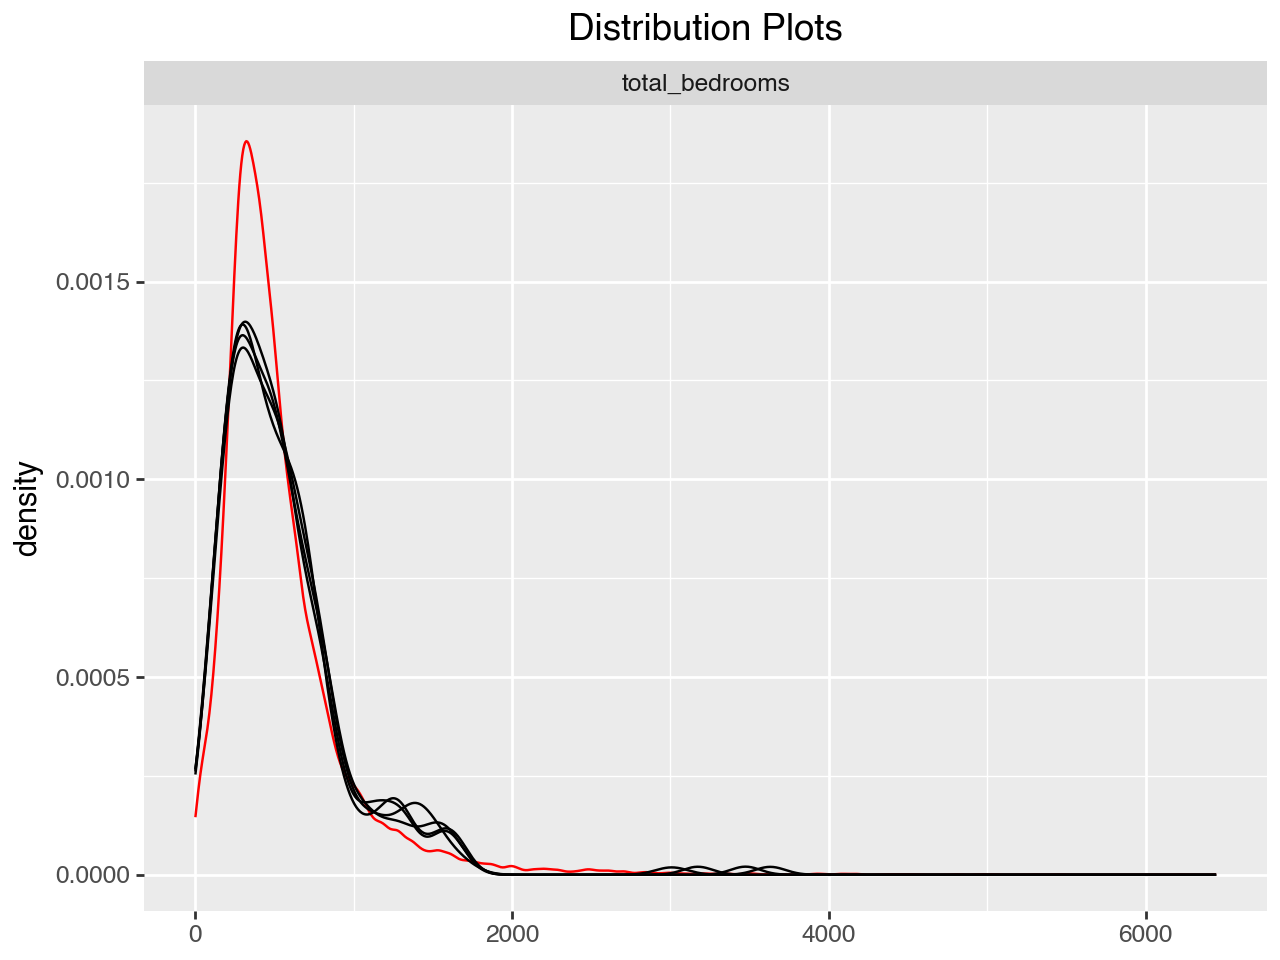

In [19]:
# Визуализация для сравнения распределения значений
kernel.plot_imputed_distributions()

По графику видим, что модель неплохо справилась с заполнением значений:

- Нет смещения;
- Хвост схож реальным распределением;
- Пик в заполненых значениях выше реального распределения, но это может быть связано с маленьким количеством пропусков.

Дополнительно проверим статистики для оригинальных и импутированных значений.

In [20]:
original = df['total_bedrooms'].dropna()
imputed = kernel.complete_data()['total_bedrooms']

print('Оригинал:')
print(f'  Среднее: {original.mean():.2f}')
print(f'  Медиана: {original.median():.2f}')
print(f'  Стандартное отклонение: {original.std():.2f}')

print('\nИмпутировано:')
print(f'  Среднее: {imputed.mean():.2f}')
print(f'  Медиана: {imputed.median():.2f}')
print(f'  Стандартное отклонение: {imputed.std():.2f}')

Оригинал:
  Среднее: 537.87
  Медиана: 435.00
  Стандартное отклонение: 421.39

Импутировано:
  Среднее: 537.90
  Медиана: 435.00
  Стандартное отклонение: 421.18


Результаты импутации показали высокую точность: среднее, медиана и стандартное отклонение импутированных значений практически совпадают с исходными. График плотности подтверждает сохранение формы распределения. Это говорит о том, что модель корректно восстановила пропущенные данные без внесения систематических искажений.

Можно с уверенностью использовать эти данные для дальнейшего анализа, визуализации и обучения моделей машинного обучения.

In [21]:
# Заменяем оригинальную на импутированную колонку
df['total_bedrooms'] = kernel.complete_data()['total_bedrooms']
# Преобразовываем категориальный признак обратно в тип данных object
df['ocean_proximity'] = df['ocean_proximity'].astype('object')

In [22]:
# Проверяем результат
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Пропуски заполнены.

### Преобразование типов данных:

Прежде, чем преобразовывать типы данных, перепроверим все ли значения в признаках целочисленные.

In [23]:
# Предварительно восстановим масштаб признака "median_income"
df['median_income'] = df['median_income'] * 10000

In [24]:
# Список признаков для проверки
int_check = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
             'households', 'median_income', 'median_house_value']

In [25]:
# Проверка, все ли значения целочисленные
for col in int_check:
    if df[col].eq(df[col].astype(int)).all():
        print(f'Признак {col} целочисленный.')
    else:
        print(f'Признак {col} имеет значения с дробной частью.')

Признак housing_median_age целочисленный.
Признак total_rooms целочисленный.
Признак total_bedrooms целочисленный.
Признак population целочисленный.
Признак households целочисленный.
Признак median_income имеет значения с дробной частью.
Признак median_house_value целочисленный.


In [26]:
# Оставляем в списке только целочисленые признаки
int_check.remove('median_income')

# Преобразование типов данных:
for col in int_check:
    df[col] = df[col].astype('int')

# Проверяем результат
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20640 non-null  int64  
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(3), int64(6), object(1)
memory usage: 1.6+ MB


Все типы данных теперь корректны.

### Явные дубликаты:

Признак `ocean_proximity` мы уже проверили на неявные дубликаты, они там отсутствуют.

Проверим данные на наличие явных дубликатов.

In [27]:
print(f'Количество дубликатов: {df.duplicated().sum()}')

Количество дубликатов: 0


Явные дубликаты отсутствуют.

### Вывод:

На данном этапе мы выполнили следующие преобразования:

- Пропущенные значения заполнены методом `MICE` с высокой точностью;

- Типы данных преобразованы в корректные значения;

- Признак `longitude` преобразован в положительные значения;

- Масштаб значений признака `median_income` изменен в изначальный, теперь он измеряется в *US Dollars*;

- Данные проверены на наличие явных и неявных дубликатов, они отсутствуют.

Теперь данные готовы для исследовательского анализа.

## Исследовательский анализ:

***Примечание:***

*К данному этапу принято решение подойти с систематическим подходом, то есть нас сразу интересует его связь таргетом. Поэтому каждый признак будет рассмотрен комплексно.*

### Количественные признаки:

In [28]:
# Переменная для целевого признака
target = df['median_house_value']

#### Признак "longitude":

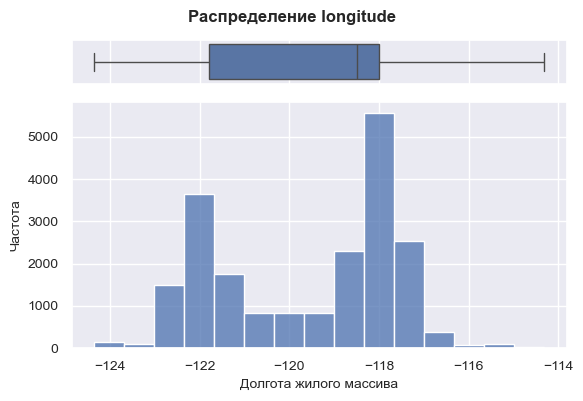

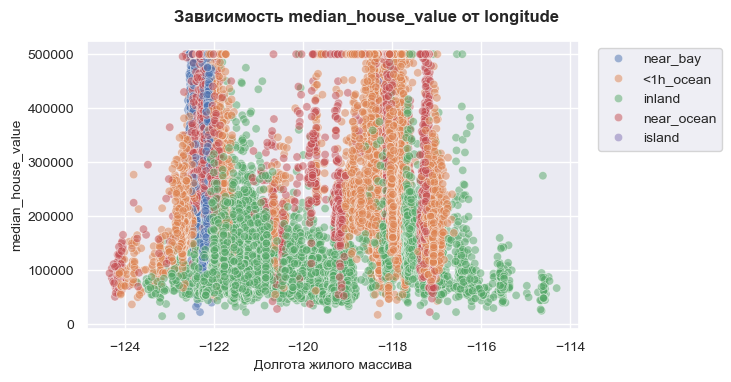

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.35,-121.8,-118.49,-118.01,-114.31


,Тест на нормальность распределения (порог=0.05):
,
Статистика:,983.426697
Критические значения:,"[0.576, 0.656, 0.787, 0.918, 1.092]"
Распределение,Не является нормальным


In [29]:
analyzis_quantity(df['longitude'], x_label='Долгота жилого массива', target=target, system=True, hue=df['ocean_proximity'])

**Вывод:**

На графиках мы явно наблюдаем 2 района, в каждом есть как и дешевая недвижимость, так и дорогая. И они напрямую не коррелируют с категориальным признаком.

#### Признак "latitude":

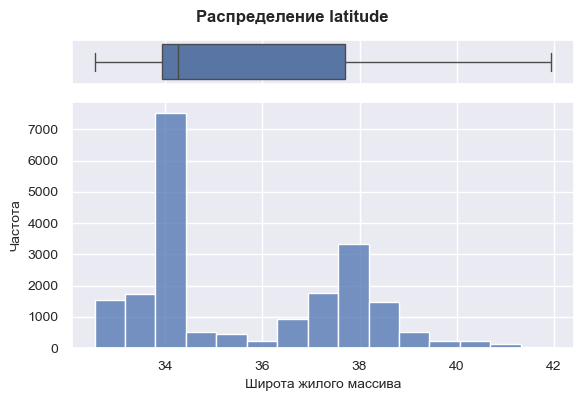

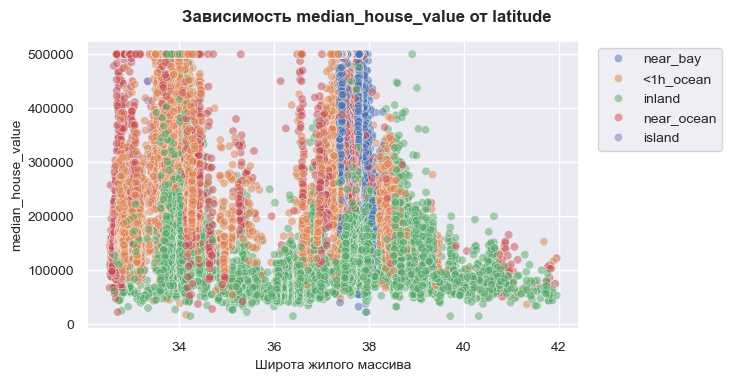

,count,mean,std,min,25%,50%,75%,max
latitude,20640.0,35.631861,2.135952,32.54,33.93,34.26,37.71,41.95


,Тест на нормальность распределения (порог=0.05):
,
Статистика:,1222.728097
Критические значения:,"[0.576, 0.656, 0.787, 0.918, 1.092]"
Распределение,Не является нормальным


In [30]:
analyzis_quantity(df['latitude'], x_label='Широта жилого массива', target=target, system=True, hue=df['ocean_proximity'])

**Вывод:**

Тут мы наблюдаем ту же картину, что и с долготой, выявлено 2 района. Необходимо рассмотреть эти признаки в совокупности.

#### Признак "latitude" и "longitude":

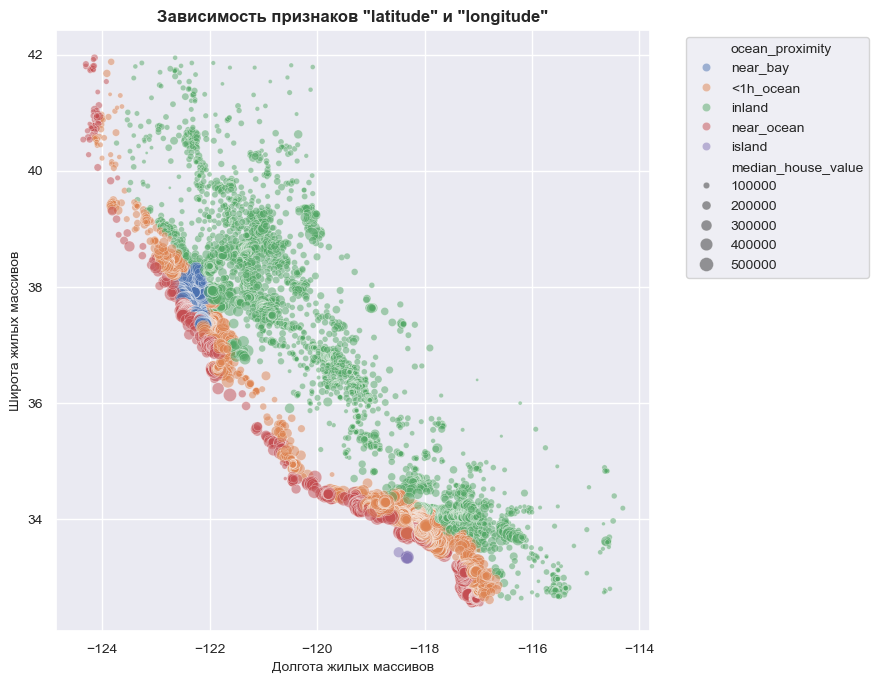

In [31]:
# Построение графика
fig, ax = plt.subplots(figsize=(9, 7))
sns.scatterplot(x=df['longitude'], y=df['latitude'], hue=df['ocean_proximity'], size=target, sizes=(5, 100), alpha=0.5)

# Настройка заголовков и подписей
plt.title('Зависимость признаков "latitude" и "longitude"', fontsize=12, fontweight='bold')
ax.set_xlabel('Долгота жилых массивов', fontsize=10)
ax.set_ylabel('Широта жилых массивов', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Отображение графика
fig.tight_layout()
plt.show()

![Карта Калифорнии](https://i.pinimg.com/736x/8d/a0/a9/8da0a909a7a83b4cd7d68f2e476de2c9.jpg)

Мы видим, что скопление жилых массивов связаны с местоположением городов, тем самым мы можем разделить наши жилые массивы либо на кластеры, либо поделить на квадраты, чтобы помочь модели определять район, так как размер точек говорит о том, что местоположение жилого массива помимо близости к океану влияет на медианную цену недвижимости.

К данному вопросу вернемся на этапе корреляционного анализа.

#### Признак "housing_median_age":

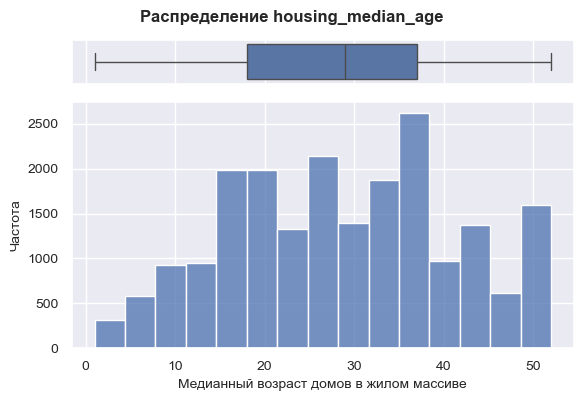

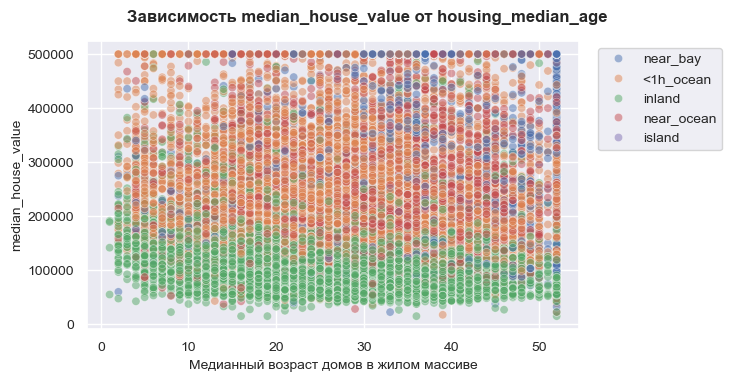

,count,mean,std,min,25%,50%,75%,max
housing_median_age,20640.0,28.639486,12.585558,1.0,18.0,29.0,37.0,52.0


,Тест на нормальность распределения (порог=0.05):
,
Статистика:,88.016061
Критические значения:,"[0.576, 0.656, 0.787, 0.918, 1.092]"
Распределение,Не является нормальным


In [32]:
analyzis_quantity(df['housing_median_age'], x_label='Медианный возраст домов в жилом массиве', 
                  target=target, system=True, hue=df['ocean_proximity'])

Данный признак выглядит достаточно зашумленно, и имеет смысл данный признак упростить, и сократить количество категорий интервалами либо по 5 или по 10 лет. 

#### Признак "total_rooms":

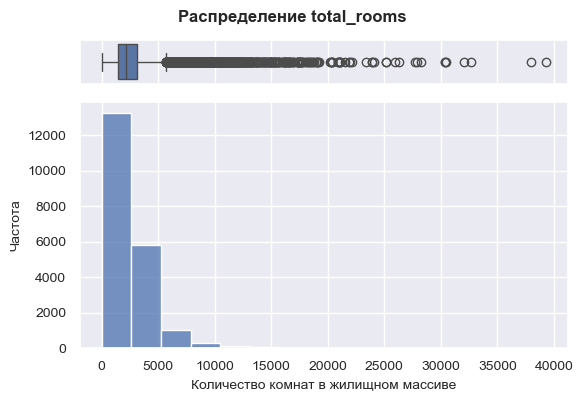

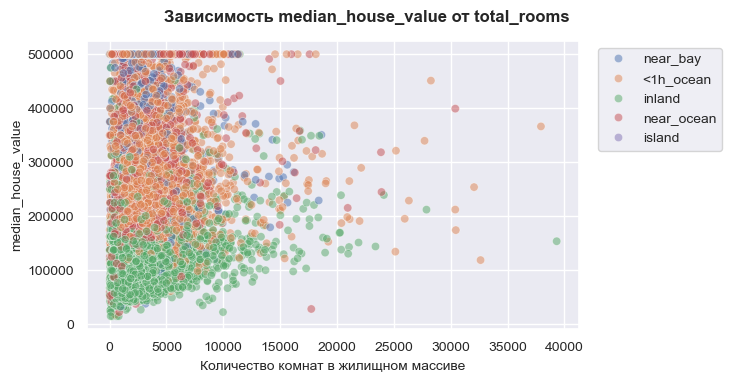

,count,mean,std,min,25%,50%,75%,max
total_rooms,20640.0,2635.763081,2181.615252,2.0,1447.75,2127.0,3148.0,39320.0


,Тест на нормальность распределения (порог=0.05):
,
Статистика:,1246.078921
Критические значения:,"[0.576, 0.656, 0.787, 0.918, 1.092]"
Распределение,Не является нормальным


In [33]:
analyzis_quantity(df['total_rooms'], x_label='Количество комнат в жилищном массиве', 
                  target=target, system=True, hue=df['ocean_proximity'])

В данном признаке мы видим довольно длинный хвост, что может мешать модели определить верный коэффициент, воспользуемся методом компрессии и последующего клипирования данных.

In [34]:
# Поиск порога сжатия
df['total_rooms'].quantile(0.95)

np.float64(6213.199999999997)

In [35]:
# Последовательная компрессия данных
df['total_rooms_comp'] = power_compress(df['total_rooms'], threshold=0.95, power=0.9)
df['total_rooms_comp'] = power_compress(df['total_rooms_comp'], threshold=0.85, power=0.9)

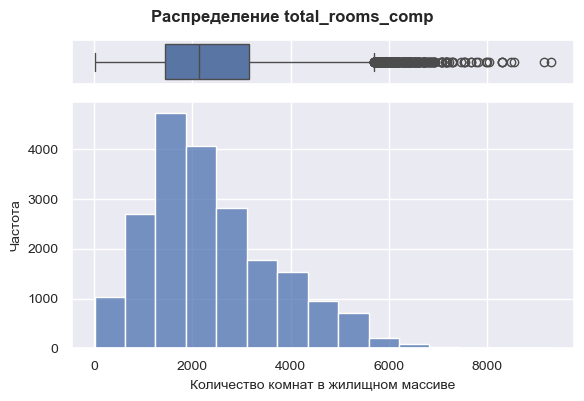

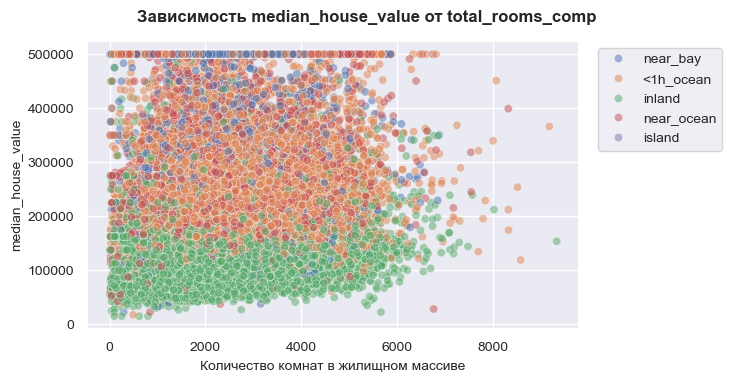

,count,mean,std,min,25%,50%,75%,max
total_rooms_comp,20640.0,2393.757383,1312.936253,2.0,1447.75,2127.0,3148.0,9318.678938


,Тест на нормальность распределения (порог=0.05):
,
Статистика:,282.037802
Критические значения:,"[0.576, 0.656, 0.787, 0.918, 1.092]"
Распределение,Не является нормальным


In [36]:
analyzis_quantity(df['total_rooms_comp'], x_label='Количество комнат в жилищном массиве', 
                  target=target, system=True, hue=df['ocean_proximity'])

In [37]:
# Оценка корреляции с таргетом до и после
print(f"Корреляция до: {df['total_rooms'].corr(df['median_house_value']):.3f}")
print(f"Корреляция после: {df['total_rooms_comp'].corr(df['median_house_value']):.3f}")

Корреляция до: 0.134
Корреляция после: 0.174


Наилучший результат дала последовательная степенная компрессия данных с разным порогом срабатывания: 

- Среднее отклонение уменьшилось **в 2 раза**;
- Квартили распределения **остались без изменений**;
- Максимальное значение сократилось **в 4 раза**;
- Линейная корреляция с таргетом **увеличилась на 30%**.

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20640 non-null  int64  
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
 10  total_rooms_comp    20640 non-null  float64
dtypes: float64(4), int64(6), object(1)
memory usage: 1.7+ MB
